In [2]:
import plasp
from plasp.methods import Plasp, Diffrac, Diffusion
from plasp.regressors import KernelRegressor, DiffusionWeights
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.sparse import rand
import random
import time
from sklearn.model_selection import train_test_split
import sys
sys.path.append(YOURPATH)
from tools import *
from screening import *
from experiment import *
%matplotlib inline

In [3]:
kernel = KernelRegressor(kernel=('linear', None))

# Generating the data

In [34]:
X, y, true_params, _ = make_data(100, 10, 0.1)
compt_exp = 0
while compt_exp < 5:
        random.seed(compt_exp)
        np.random.seed(compt_exp)
        compt_exp += 1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        print(y_test)

[-0.73006508 -0.05340228  0.72584206 -0.9641448  -0.00465883 -0.07392834
  0.54777992  0.014378   -0.83373855  0.14369398  0.29597402  0.10794302
  0.54721455  0.86536453  0.19535304 -0.31532477  0.1428103   0.83167196
 -0.33451877  0.41933129]
[  5.36349110e-01  -8.54999073e-01  -3.34518773e-01  -3.25537443e-01
  -7.39283429e-02  -6.44274000e-01   6.23895423e-01   5.60618020e-01
  -1.48876789e-01  -1.07511107e-01   1.07943016e-01   9.08907629e-01
  -5.52803880e-04   1.75612933e-01  -3.53206522e-01   1.00590897e-01
   2.83619782e-01   8.18088737e-01   5.47214554e-01  -7.41349879e-02]
[  6.83652437e-01  -3.15324767e-01  -5.52803880e-04   8.31671959e-01
   5.47779915e-01  -2.33175101e-01   7.25842056e-01  -1.68126581e-01
   8.40329234e-01   8.65364527e-01   7.04281753e-01   1.07943016e-01
   7.68938497e-01  -5.34488347e-01  -9.97094973e-01  -6.63337852e-01
   8.72187898e-02  -5.88157158e-01  -5.32554727e-01   8.83385507e-01]
[-0.07392834 -0.07216288  0.06975447  0.39681155  0.16298189  0

In [35]:
def train_interval(X, y, mu, lmbda):
    method = Diffrac('IR', kernel)
    s_train = np.empty((X.shape[0], 2))
    s_train[:,0] = y
    s_train[:,1] = mu
    method.train(X, s_train, lambd=lmbda)
    dim = 5
    x = X[:, dim]
    ind = np.argsort(x)
    
    fig, [ax_1, ax_2] = plt.subplots(1, 2, figsize=(16, 8))
    
    a = ax_1.errorbar(X[ind,dim], s_train[ind, 0], yerr=s_train[ind, 1], fmt='o', color="C0")
    b, = ax_1.plot(X[ind,dim], y[ind], linestyle="-", linewidth=3, color="C1")
    c, = ax_1.plot(X[ind,dim], method(X)[ind], linestyle="--", linewidth=3, color="C2")
    if hasattr(method, 'y_dis'):
        d = ax_1.scatter(X[:,dim], method.y_dis, linestyle="-", linewidth=3, color="C2")
        ax_1.legend([d, c, b, a], ["Reconstruction", "Disambiguation", "Signal", "Samples"],
                    prop={"size": 15})
    else:
        ax_1.legend([c, b, a], ["Reconstruction", "Signal", "Samples"], prop={"size": 15})
        ax_1.set_title("Learning", size=20)
        
    a, = ax_2.plot(X[ind,dim], y[ind])
    b, = ax_2.plot(X[ind,dim], method(X)[ind])
    ax_2.legend([a, b], ["Signal", "Reconstruction"], prop={"size": 15})
    return method

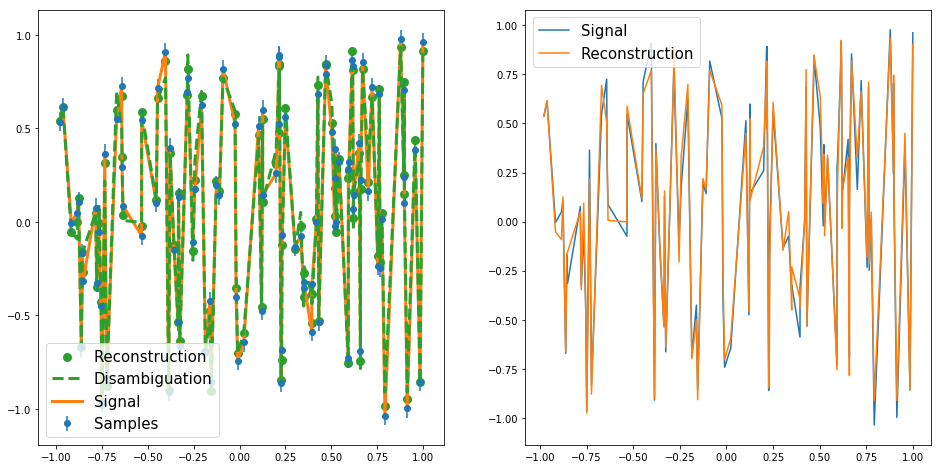

In [36]:
mu = 0.05
lmbda = 0.0000001
method = train_interval(X, y, mu, lmbda)
y_predict = method(X)

# Screening the data

In [37]:
results = test_dataset_accelerated(X, y, lmbda=lmbda, mu=mu, classification=False, loss='truncated_squared',
                                   penalty='l2', n_steps=1000, intercept=False, cut=True)
results

Time to compute z and A: 0.8194773197174072
Time to test the entire dataset: 0.030855178833007812


array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.])

In [38]:
X_screened = X[np.where(results == 0)[0]]
y_screened = y[np.where(results == 0)[0]]

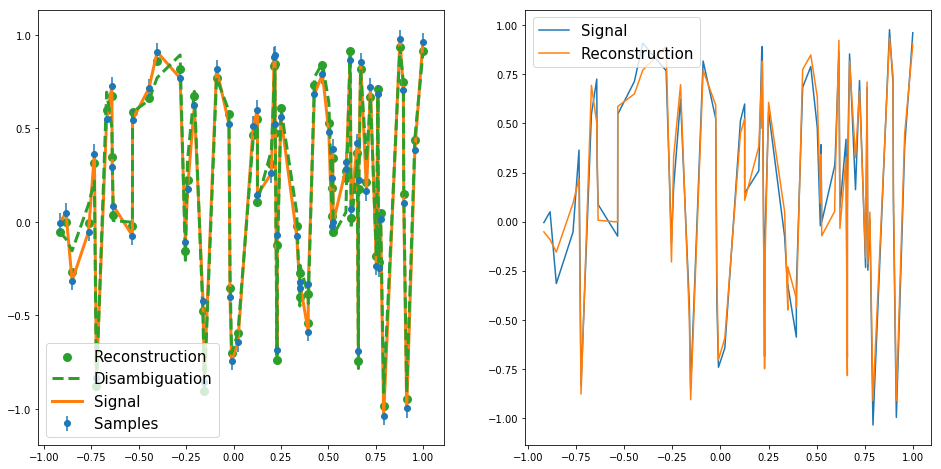

In [39]:
method_screened = train_interval(X_screened, y_screened, mu, lmbda)
y_predict_screened = method_screened(X)

In [40]:
print(y_predict.shape, y.shape, y_predict_screened.shape)
scoring_interval_regression(y, y_predict, y_predict_screened, mu)

(100,) (100,) (100,)


1.0

In [41]:
error_color= []
for i in range(len(results)):
    if results[i] == 0:
        error_color.append('tomato')
    else:
        error_color.append('cornflowerblue')
error_color

np.where(results == 1)[0]

array([ 1,  7, 14, 19, 21, 22, 24, 26, 27, 28, 35, 42, 46, 55, 56, 57, 60,
       61, 64, 69, 70, 71, 72, 77, 80, 81, 89, 90, 92, 94, 95, 98])

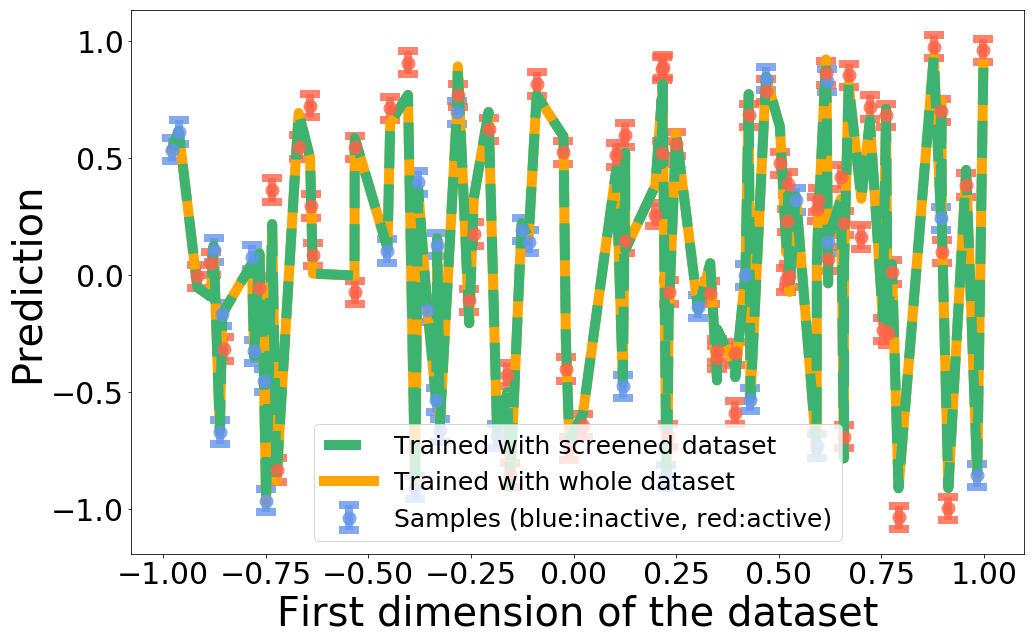

In [42]:
s_train = np.empty((X.shape[0], 2))
s_train[:,0] = y
s_train[:,1] = mu

dim = 5
x = X[:, dim]
ind = np.argsort(x)

ones = np.where(results == 1)[0]
zeros = np.where(results == 0)[0]

fig, ax_1 = plt.subplots(figsize=(16, 10))
a = ax_1.errorbar(X[ones,dim], s_train[ones, 0], yerr=s_train[ones, 1], linewidth=8, fmt='o', 
                  color='cornflowerblue', alpha=0.8, capsize=10, markeredgewidth=8)
a_ = ax_1.errorbar(X[zeros,dim], s_train[zeros, 0], yerr=s_train[zeros, 1], linewidth=8, fmt='o', 
                   color='tomato', alpha=0.8,
                   capsize=10, markeredgewidth=8)
b, = ax_1.plot(X[ind,dim], y_predict[ind], linestyle="-", linewidth=10, color='orange')
c, = ax_1.plot(X[ind,dim], y_predict_screened[ind], linestyle="--", linewidth=10, color='mediumseagreen')
if hasattr(method, 'y_dis'):
    ax_1.legend([c, b, a], ["Trained with screened dataset", "Trained with whole dataset", "Samples (blue:inactive, red:active)"],
                prop={"size": 25})
    
else:
    ax_1.legend([c, b, a], ["Reconstruction", "Signal", "Samples"], prop={"size": 20})
    ax_1.set_title("Learning", size=30)
ax_1.set_xlabel('First dimension of the dataset', fontsize=40)
ax_1.set_ylabel('Prediction', fontsize=40)
ax_1.tick_params(axis='x', labelsize=30)
ax_1.tick_params(axis='y', labelsize=30)
